In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb
import xgboost as xgb
from Utils.calculate_metrics import calculate_multiclass_metrics
from sklearn import preprocessing

from joblib import dump, load
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("./data/train.csv", parse_dates=['survey_time'],encoding='latin-1') 
test = pd.read_csv("./data/test.csv", parse_dates=['survey_time'],encoding='latin-1') #latin-1向下兼容ASCII


def pre_processing_augmentation(train, test):
    train = train[train["happiness"]!=-8].reset_index(drop=True)
    train_data_copy = train.copy() #删去"happiness" 为-8的行
    target_col = "happiness" #目标列
    target = train_data_copy[target_col]

    test = test[test["happiness"]!=-8].reset_index(drop=True)
    test_label = test[target_col]



    del test['happiness']
    del train_data_copy[target_col] #去除目标列

    data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)
    # print(data.shape)

    #make feature +5
    #csv中有复数值：-1、-2、-3、-8，将他们视为有问题的特征，但是不删去
    def getres1(row):
        return len([x for x in row.values if type(x)==int and x<0])

    def getres2(row):
        return len([x for x in row.values if type(x)==int and x==-8])

    def getres3(row):
        return len([x for x in row.values if type(x)==int and x==-1])

    def getres4(row):
        return len([x for x in row.values if type(x)==int and x==-2])

    def getres5(row):
        return len([x for x in row.values if type(x)==int and x==-3])

    #检查数据
    data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
    data.loc[data['neg1']>20,'neg1'] = 20  #平滑处理

    data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
    data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
    data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
    data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)

    #填充缺失值 共25列 去掉4列 填充21列
    #以下的列都是缺省的，视情况填补
    data['work_status'] = data['work_status'].fillna(0)
    data['work_yr'] = data['work_yr'].fillna(0)
    data['work_manage'] = data['work_manage'].fillna(0)
    data['work_type'] = data['work_type'].fillna(0)

    data['edu_yr'] = data['edu_yr'].fillna(0)
    data['edu_status'] = data['edu_status'].fillna(0)

    data['s_work_type'] = data['s_work_type'].fillna(0)
    data['s_work_status'] = data['s_work_status'].fillna(0)
    data['s_political'] = data['s_political'].fillna(0)
    data['s_hukou'] = data['s_hukou'].fillna(0)
    data['s_income'] = data['s_income'].fillna(0)
    data['s_birth'] = data['s_birth'].fillna(0)
    data['s_edu'] = data['s_edu'].fillna(0)
    data['s_work_exper'] = data['s_work_exper'].fillna(0)

    data['minor_child'] = data['minor_child'].fillna(0)
    data['marital_now'] = data['marital_now'].fillna(0)
    data['marital_1st'] = data['marital_1st'].fillna(0)
    data['social_neighbor']=data['social_neighbor'].fillna(0)
    data['social_friend']=data['social_friend'].fillna(0)
    data['hukou_loc']=data['hukou_loc'].fillna(1) #最少为1，表示户口
    data['family_income']=data['family_income'].fillna(66365) #删除问题值后的平均值

    #144+1 =145
    #继续进行特殊的列进行数据处理
    #读happiness_index.xlsx
    data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')#防止时间格式不同的报错errors='coerce‘
    data['survey_time'] = data['survey_time'].dt.year #仅仅是year，方便计算年龄
    data['age'] = data['survey_time']-data['birth']
    # print(data['age'],data['survey_time'],data['birth'])
    #年龄分层 145+1=146
    bins = [0,17,26,34,50,63,100]
    data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5]) 

    #对‘宗教’处理
    data.loc[data['religion']<0,'religion'] = 1 #1为不信仰宗教
    data.loc[data['religion_freq']<0,'religion_freq'] = 1 #1为从来没有参加过
    #对‘教育程度’处理
    data.loc[data['edu']<0,'edu'] = 4 #初中
    data.loc[data['edu_status']<0,'edu_status'] = 0
    data.loc[data['edu_yr']<0,'edu_yr'] = 0
    #对‘个人收入’处理
    data.loc[data['income']<0,'income'] = 0 #认为无收入
    #对‘政治面貌’处理
    data.loc[data['political']<0,'political'] = 1 #认为是群众
    #对体重处理
    data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
    data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2  #个人的想法，哈哈哈，没有60斤的成年人吧
    #对身高处理
    data.loc[data['height_cm']<150,'height_cm'] = 150 #成年人的实际情况
    #对‘健康’处理
    data.loc[data['health']<0,'health'] = 4 #认为是比较健康
    data.loc[data['health_problem']<0,'health_problem'] = 4
    #对‘沮丧’处理
    data.loc[data['depression']<0,'depression'] = 4 #一般人都是很少吧
    #对‘媒体’处理
    data.loc[data['media_1']<0,'media_1'] = 1 #都是从不
    data.loc[data['media_2']<0,'media_2'] = 1
    data.loc[data['media_3']<0,'media_3'] = 1
    data.loc[data['media_4']<0,'media_4'] = 1
    data.loc[data['media_5']<0,'media_5'] = 1
    data.loc[data['media_6']<0,'media_6'] = 1
    #对‘空闲活动’处理
    data.loc[data['leisure_1']<0,'leisure_1'] = 1 #都是根据自己的想法
    data.loc[data['leisure_2']<0,'leisure_2'] = 5
    data.loc[data['leisure_3']<0,'leisure_3'] = 3

    data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode() #取众数
    data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
    data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
    data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
    data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
    data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
    data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
    data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
    data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
    data.loc[data['socialize']<0,'socialize'] = 2 #很少
    data.loc[data['relax']<0,'relax'] = 4 #经常
    data.loc[data['learn']<0,'learn'] = 1 #从不，哈哈哈哈
    #对‘社交’处理
    data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
    data.loc[data['social_friend']<0,'social_friend'] = 0
    data.loc[data['socia_outing']<0,'socia_outing'] = 1
    data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
    #对‘社会公平性’处理
    data.loc[data['equity']<0,'equity'] = 4
    #对‘社会等级’处理
    data.loc[data['class_10_before']<0,'class_10_before'] = 3
    data.loc[data['class']<0,'class'] = 5
    data.loc[data['class_10_after']<0,'class_10_after'] = 5
    data.loc[data['class_14']<0,'class_14'] = 2
    #对‘工作情况’处理
    data.loc[data['work_status']<0,'work_status'] = 0
    data.loc[data['work_yr']<0,'work_yr'] = 0
    data.loc[data['work_manage']<0,'work_manage'] = 0
    data.loc[data['work_type']<0,'work_type'] = 0
    #对‘社会保障’处理
    data.loc[data['insur_1']<0,'insur_1'] = 1
    data.loc[data['insur_2']<0,'insur_2'] = 1
    data.loc[data['insur_3']<0,'insur_3'] = 1
    data.loc[data['insur_4']<0,'insur_4'] = 1
    data.loc[data['insur_1']==0,'insur_1'] = 0
    data.loc[data['insur_2']==0,'insur_2'] = 0
    data.loc[data['insur_3']==0,'insur_3'] = 0
    data.loc[data['insur_4']==0,'insur_4'] = 0

    #对家庭情况处理
    family_income_mean = data['family_income'].mean()
    data.loc[data['family_income']<0,'family_income'] = family_income_mean
    data.loc[data['family_m']<0,'family_m'] = 2
    data.loc[data['family_status']<0,'family_status'] = 3
    data.loc[data['house']<0,'house'] = 1
    data.loc[data['car']<0,'car'] = 0
    data.loc[data['car']==2,'car'] = 0 #变为0和1
    data.loc[data['son']<0,'son'] = 1
    data.loc[data['daughter']<0,'daughter'] = 0
    data.loc[data['minor_child']<0,'minor_child'] = 0
    #对‘婚姻’处理
    data.loc[data['marital_1st']<0,'marital_1st'] = 0
    data.loc[data['marital_now']<0,'marital_now'] = 0
    #对‘配偶’处理
    data.loc[data['s_birth']<0,'s_birth'] = 0
    data.loc[data['s_edu']<0,'s_edu'] = 0
    data.loc[data['s_political']<0,'s_political'] = 0
    data.loc[data['s_hukou']<0,'s_hukou'] = 0
    data.loc[data['s_income']<0,'s_income'] = 0
    data.loc[data['s_work_type']<0,'s_work_type'] = 0
    data.loc[data['s_work_status']<0,'s_work_status'] = 0
    data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
    #对‘父母情况’处理
    data.loc[data['f_birth']<0,'f_birth'] = 1945
    data.loc[data['f_edu']<0,'f_edu'] = 1
    data.loc[data['f_political']<0,'f_political'] = 1
    data.loc[data['f_work_14']<0,'f_work_14'] = 2
    data.loc[data['m_birth']<0,'m_birth'] = 1940
    data.loc[data['m_edu']<0,'m_edu'] = 1
    data.loc[data['m_political']<0,'m_political'] = 1
    data.loc[data['m_work_14']<0,'m_work_14'] = 2
    #和同龄人相比社会经济地位
    data.loc[data['status_peer']<0,'status_peer'] = 2
    #和3年前比社会经济地位
    data.loc[data['status_3_before']<0,'status_3_before'] = 2
    #对‘观点’处理
    data.loc[data['view']<0,'view'] = 4
    #对期望年收入处理
    data.loc[data['inc_ability']<=0,'inc_ability']= 2
    inc_exp_mean = data['inc_exp'].mean()
    data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean #取均值

    #部分特征处理，取众数（首先去除缺失值的数据）
    for i in range(1, 9 + 1):
        mode_value = data['public_service_' + str(i)].dropna().mode().values[0]
        data.loc[data['public_service_' + str(i)] < 0, 'public_service_' + str(i)] = mode_value

    for i in range(1, 13 + 1):
        mode_value = data['trust_' + str(i)].dropna().mode().values[0]
        data.loc[data['trust_' + str(i)] < 0, 'trust_' + str(i)] = mode_value

    #第一次结婚年龄 147
    data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
    #最近结婚年龄 148
    data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
    #是否再婚 149
    data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
    #配偶年龄 150
    data['marital_sbir'] = data['marital_now']-data['s_birth']
    #配偶年龄差 151
    data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

    #收入比 151+7 =158
    data['income/s_income'] = data['income']/(data['s_income']+1) #同居伴侣
    data['income+s_income'] = data['income']+(data['s_income']+1)
    data['income/family_income'] = data['income']/(data['family_income']+1)
    data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
    data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
    data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
    data['income/m'] = data['income']/(data['family_m']+0.01)

    #收入/面积比 158+4=162
    data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
    data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
    data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
    data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

    #class 162+3=165
    data['class_10_diff'] = (data['class_10_after'] - data['class'])
    data['class_diff'] = data['class'] - data['class_10_before']
    data['class_14_diff'] = data['class'] - data['class_14']
    #悠闲指数 166
    leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
    data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew
    #满意指数 167
    public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
    data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

    #信任指数 168
    trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
    data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

    #province mean 168+13=181
    data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
    data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
    data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
    data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
    data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
    data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
    data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
    data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
    data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
    data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
    data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
    data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
    data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

    #city   mean 181+13=194
    data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values #按照city分组
    data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
    data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
    data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
    data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
    data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
    data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
    data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
    data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
    data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
    data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
    data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
    data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

    #county  mean 194 + 13 = 207
    data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
    data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
    data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
    data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
    data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
    data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
    data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
    data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
    data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
    data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
    data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
    data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
    data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

    #ratio 相比同省 207 + 13 =220
    data['income/province'] = data['income']/(data['province_income_mean'])                                      
    data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
    data['equity/province'] = data['equity']/(data['province_equity_mean'])       
    data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
    data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
    data['health/province'] = data['health']/(data['province_health_mean'])
    data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
    data['class/province'] = data['class']/(data['province_class_mean'])
    data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
    data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
    data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
    data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
    data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

    #ratio 相比同市 220 + 13 =233
    data['income/city'] = data['income']/(data['city_income_mean'])                                      
    data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
    data['equity/city'] = data['equity']/(data['city_equity_mean'])       
    data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
    data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
    data['health/city'] = data['health']/(data['city_health_mean'])
    data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
    data['class/city'] = data['class']/(data['city_class_mean'])
    data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
    data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
    data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
    data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
    data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])

    #ratio 相比同个地区 233 + 13 =246
    data['income/county'] = data['income']/(data['county_income_mean'])                                      
    data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
    data['equity/county'] = data['equity']/(data['county_equity_mean'])       
    data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
    data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
    data['health/county'] = data['health']/(data['county_health_mean'])
    data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
    data['class/county'] = data['class']/(data['county_class_mean'])
    data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
    data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
    data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
    data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
    data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])

    #age   mean 246+ 13 =259
    data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
    data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
    data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
    data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
    data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
    data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
    data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
    data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
    data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
    data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
    data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
    data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
    data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values

    # 和同龄人相比259 + 13 =272
    data['income/age'] = data['income']/(data['age_income_mean'])                                      
    data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
    data['equity/age'] = data['equity']/(data['age_equity_mean'])       
    data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
    data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
    data['health/age'] = data['health']/(data['age_health_mean'])
    data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
    data['class/age'] = data['class']/(data['age_class_mean'])
    data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
    data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
    data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
    data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
    data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])
    #272-9=263
    #删除数值特别少的和之前用过的特征
    del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
    use_feature = [clo for clo in data.columns if clo not in del_list]
    data.fillna(0,inplace=True) #还是补0
    train_shape = train.shape[0] #一共的数据量，训练集
    features = data[use_feature].columns #删除后所有的特征
    X_train_263 = data[:train_shape][use_feature].values
    y_train = target
    y_test = test_label
    X_test_263 = data[train_shape:][use_feature].values
    X_train_263.shape #最终一种263个特征
    
    return X_train_263, y_train, X_test_263, y_test

(7190, 263)

In [3]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
           'equity/province','equity/city','equity/county',
           'depression/province','depression/city','depression/county',
           'health/province','health/city','health/county',
           'class/province','class/city','class/county',
           'family_status/province','family_status/city','family_status/county',
           'family_income/province','family_income/city','family_income/county',
           'floor_area/province','floor_area/city','floor_area/county',
           'leisure_sum/province','leisure_sum/city','leisure_sum/county',
           'public_service_sum/province','public_service_sum/city','public_service_sum/county',
           'trust_sum/province','trust_sum/city','trust_sum/county',
           'income/m','public_service_sum','class_diff','status_3_before','age_income_mean','age_floor_area_mean',
           'weight_jin','height_cm',
           'health/age','depression/age','equity/age','leisure_sum/age'
          ]
train_shape = train.shape[0]
X_train_49 = data[:train_shape][imp_fea_49].values
X_test_49 = data[train_shape:][imp_fea_49].values
X_train_49.shape #最重要的49个特征

cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14'] #已经是0、1的值不需要onehot
noc_fea = [clo for clo in use_feature if clo not in cat_fea]

onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories = 'auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape #变为onehot编码格式

X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape #其中的训练集

X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])#先是noc，再是cat_fea
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7190, 383)

In [6]:
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.metrics import mean_squared_error


lgb_263_param = {
'num_leaves': 7, 
'min_data_in_leaf': 20, #叶子可能具有的最小记录数
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.003,
"boosting": "gbdt", #用gbdt算法
"feature_fraction": 0.18, #例如 0.18时，意味着在每次迭代中随机选择18％的参数来建树
"bagging_freq": 1,
"bagging_fraction": 0.55, #每次迭代时用的数据比例
"bagging_seed": 14,
"metric": 'mse',
"lambda_l1": 0.1,
"lambda_l2": 0.2, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)   #交叉切分：5
oof_lgb_263 = np.zeros(len(X_train_263))
predictions_lgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, y_train)):

    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_263[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train_263[val_idx], y_train[val_idx])#train:val=4:1

    num_round = 10000
    lgb_263 = lgb.train(lgb_263_param, trn_data, num_round, valid_sets = [trn_data, val_data])
    oof_lgb_263[val_idx] = lgb_263.predict(X_train_263[val_idx], num_iteration=lgb_263.best_iteration)
    predictions_lgb_263 += lgb_263.predict(X_test_263, num_iteration=lgb_263.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_263, target)))


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.44679717


In [8]:
from sklearn import model_selection
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn import metrics

kf = model_selection.KFold(n_splits=5, shuffle=True)
mse = []

oof_preds = np.zeros(len(X_train_263))  # 用于存储每折验证集的预测结果

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 使用 KFold 进行数据分割

# 遍历每一折
for fold_, (train_idx, val_idx) in enumerate(kf.split(X_train_263)):
    print(f"Fold {fold_ + 1}")
    
    # 获取当前折的训练集和验证集
    x_train, y_train = X_train_263[train_idx], target[train_idx]
    x_val, y_val = X_train_263[val_idx], target[val_idx]
    
    # 定义并训练模型
    model = lgb.LGBMRegressor(
        num_leaves=7,
        min_data_in_leaf=20,
        objective='regression',
        max_depth=-1,
        learning_rate=0.003,
        boosting='gbdt',
        feature_fraction=0.18,
        bagging_freq=1,
        bagging_fraction=0.55,
        bagging_seed=14,
        metric='mse',
        lambda_l1=0.1,
        lambda_l2=0.2,
        verbosity=-1,
        n_estimators=10000
    )
    model.fit(x_train, y_train)
    
    # 对当前折验证集进行预测
    oof_preds[val_idx] = model.predict(x_val)

# 计算整体 MSE
cv_score = mean_squared_error(target, oof_preds)
print(f"CV score: {cv_score:.8f}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
CV score: 0.44655984


In [10]:
from sklearn import metrics
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold

kf = model_selection.KFold(n_splits=5, shuffle=True)

mse = []
accs = []
for train, test in kf.split(X_train_263, target):
    x_train = X_train_263[train]
    y_train = target[train]
    x_test = X_train_263[test]
    y_test = target[test]
    model = lgb.LGBMRegressor(num_leaves=7,min_data_in_leaf=20,objective='regression',max_depth=-1,learning_rate=0.003,
                              boosting='gbdt',feature_fraction=0.18,bagging_freq=1,bagging_fraction=0.55,bagging_seed=14,
                              metric='mse',lambda_l1=0.1,lambda_l2=0.2,verbosity=-1, n_estimators=10000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse.append(mean_squared_error(y_test, y_pred))
    accs.append(metrics.accuracy_score(y_test, np.round(y_pred)))
    
print(f"mse: {np.mean(mse)}, acc: {np.mean(accs)}")

mse: 0.44782608230785914, acc: 0.6201668984700974


In [13]:
# Test xgboost

import sklearn.metrics
from sklearn.metrics import mean_squared_error
import xgboost as xgb
kf = model_selection.KFold(n_splits=5, shuffle=True)
mse = []
accs = []
fold = 0
for train, test in kf.split(X_train_263, target):
    print(f"Fold {fold + 1}")
    fold += 1
    x_train = X_train_263[train]
    y_train = target[train]
    x_test = X_train_263[test]
    y_test = target[test]
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.003)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse.append(mean_squared_error(y_test, y_pred))
    accs.append(metrics.accuracy_score(y_test, np.round(y_pred)))
    
print(f"mse: {np.mean(mse)}, acc: {np.mean(accs)}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
mse: 0.4688844220415148, acc: 0.6146036161335188


In [6]:
from sklearn import linear_model
from sklearn import metrics
ridge = linear_model.Ridge(alpha=0.5)
ridge.fit(X_train_263, target)

y_pred = ridge.predict(X_test_263)
y_pred = np.round(y_pred)

mse = metrics.mean_squared_error(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred)

mse, acc

(0.6127819548872181, 0.5651629072681704)

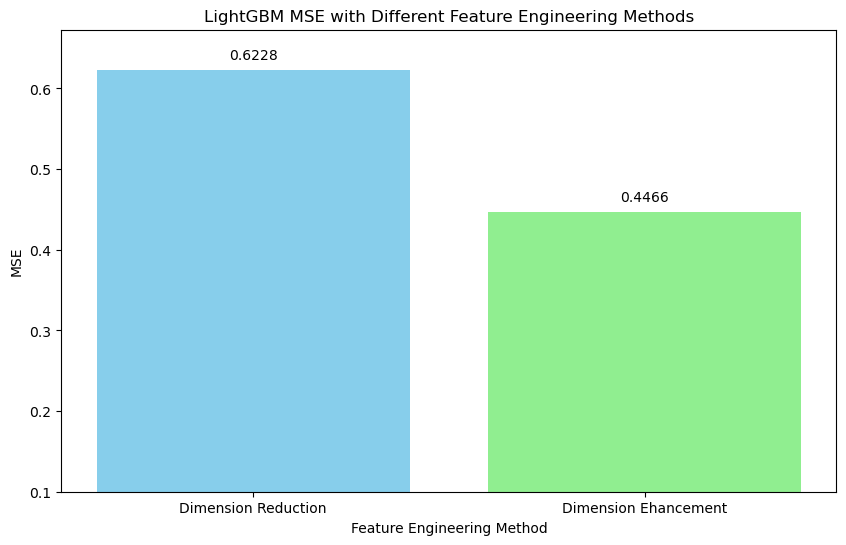

In [11]:
import matplotlib.pyplot as plt

# 定义特征工程方法和对应的MSE
methods = ['Dimension Reduction', 'Dimension Ehancement']
mse_values = [0.6228, 0.4466]

# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values, color=['skyblue', 'lightgreen'])

# 添加标题和标签
plt.title('LightGBM MSE with Different Feature Engineering Methods')
plt.xlabel('Feature Engineering Method')
plt.ylabel('MSE')
plt.ylim(0.1, max(mse_values) + 0.05)  # 设置y轴最小值为0.3

# 显示数值
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

# 显示图表
plt.show()

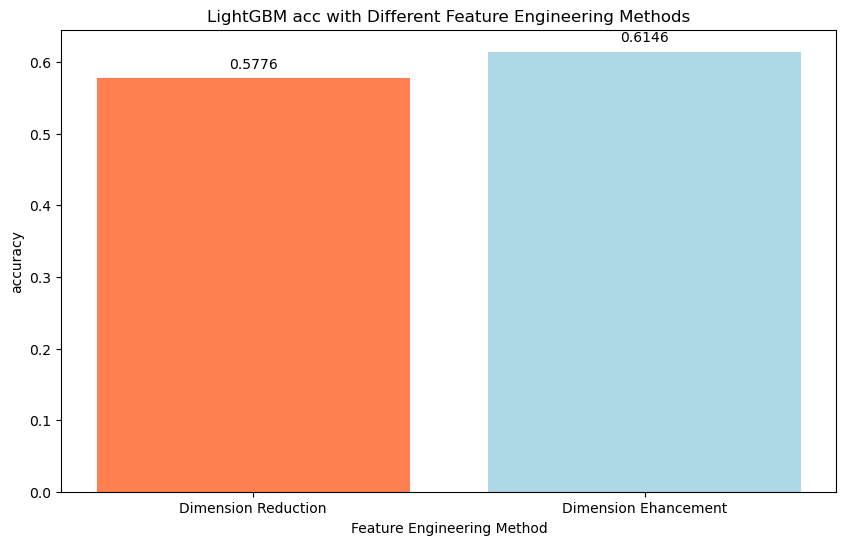

In [12]:
methods = ['Dimension Reduction', 'Dimension Ehancement']
acc_values = [0.5776, 0.6146]

# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(methods, acc_values, color=['coral', 'lightblue'])

# 添加标题和标签
plt.title('LightGBM acc with Different Feature Engineering Methods')
plt.xlabel('Feature Engineering Method')
plt.ylabel('accuracy')
# plt.ylim(0, max(mse_values) + 0.05)  # 设置y轴最小值为0.3

# 显示数值
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

# 显示图表
plt.show()

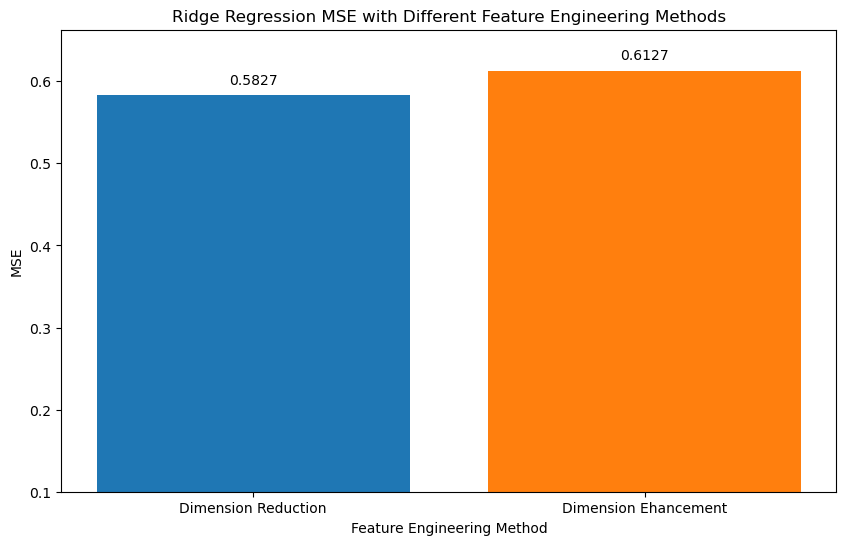

In [13]:
import matplotlib.pyplot as plt

# 定义特征工程方法和对应的MSE
methods = ['Dimension Reduction', 'Dimension Ehancement']
mse_values = [0.5827, 0.6127]

# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values, color=['#1f77b4', '#ff7f0e'])

# 添加标题和标签
plt.title('Ridge Regression MSE with Different Feature Engineering Methods')
plt.xlabel('Feature Engineering Method')
plt.ylabel('MSE')
plt.ylim(0.1, max(mse_values) + 0.05)  # 设置y轴最小值为0.3

# 显示数值
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

# 显示图表
plt.show()

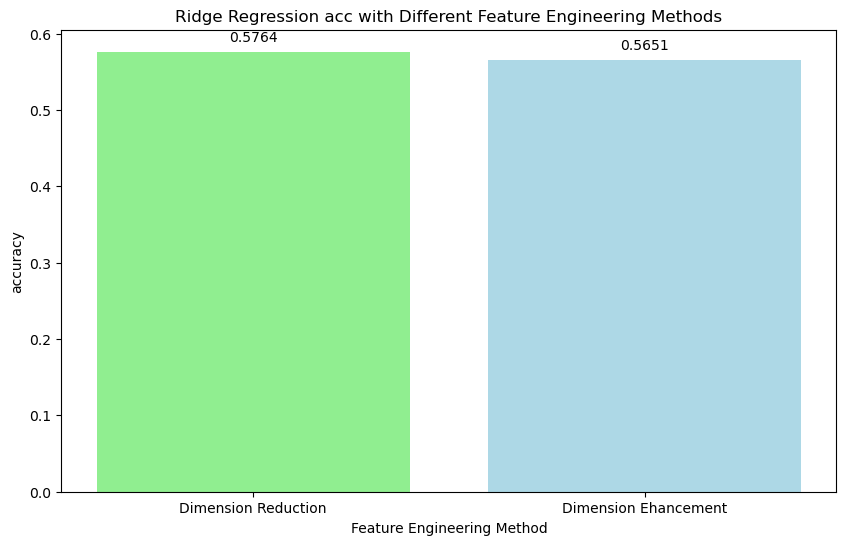

In [15]:
methods = ['Dimension Reduction', 'Dimension Ehancement']
acc_values = [0.5764, 0.5651]

# 创建柱状图
plt.figure(figsize=(10, 6))
plt.bar(methods, acc_values, color=['lightgreen', 'lightblue'])

# 添加标题和标签
plt.title('Ridge Regression acc with Different Feature Engineering Methods')
plt.xlabel('Feature Engineering Method')
plt.ylabel('accuracy')
# plt.ylim(0, max(mse_values) + 0.05)  # 设置y轴最小值为0.3

# 显示数值
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.01, str(v), ha='center', va='bottom')

# 显示图表
plt.show()